In [2]:
#| default_exp analysis

In [5]:
#| export
import numpy as np
import math

In [8]:
import matplotlib.pyplot as plt

# Direct analysis on trajectories

## Angle calculation
Given a set of trajectories, calculate the angles between displacements

In [ ]:
#| export 
def get_angle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def dataset_angles(trajs):
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

# MSD based analysis 
This class collects all analysis of trajectories based on the mean squared displacement (MSD)

In [ ]:
 tamsd = np.zeros_like(t_lags, dtype= float)
        for idx, t in enumerate(t_lags):        
            for p in range(len(traj)-t):
                tamsd[idx] += (traj[p]-traj[p+t])**2            
            tamsd[idx] /= len(traj)-t    
        return tamsd

In [130]:
#| export
class msd_analysis():
    def __init__(self):
        ''' Constructor of the class'''
        

    def tamsd(self, traj, t_lags):
        '''
        Calculates the time average mean squared displacement of a trajecotry traj
        at various time lags
        Inputs: - traj: trajectory to calculate TA-MSD
                - t_lags: time lags used for the TA-MSD
        Outputs: - TA-MSD
        '''
        tamsd = np.zeros_like(t_lags, dtype= float)
        for idx, t in enumerate(t_lags):        
            for p in range(len(traj)-t):
                tamsd[idx] += (traj[p]-traj[p+t])**2            
            tamsd[idx] /= len(traj)-t    
        return tamsd

    def get_diff_coeff(self, traj, t_lags = None):
        '''Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD'''
        if not t_lags:
            N_t_lags = max(4, int(len(traj)*0.1))
            t_lags = np.arange(1, N_t_lags)

        tasmd = self.tamsd(traj, t_lags)
        return np.polyfit(t_lags, tasmd, deg = 1)[0]/2

    def get_exponent(self, traj, t_lags = None):
        '''Calculates the anolaous of a trajectory by means of the linear
        fitting of the logarithm of the TA-MSD'''
        if not t_lags:
            N_t_lags = max(4, int(len(traj)*0.1))
            t_lags = np.arange(1, N_t_lags)

        tasmd = self.tamsd(traj, t_lags)
        return np.polyfit(np.log(t_lags), np.log(tasmd), deg = 1)[0]
    
    

In [132]:
pos = np.cumsum(np.random.randn(1000))
msd_analysis().get_exponent(pos)

0.94792546614116

# Velocity Autocorrelation Function (VACF)

In [15]:
#| export
def velocity(trajs, delta_t=1):
    dy = trajs[: ,delta_t:] - trajs[:,:-delta_t]
    return dy/delta_t

def vacf(trajs, delta_t = 1, taus = None):
    '''Calculates the velocity autocorrelation function for 
    the given set of trajectories.
    Args:
        :trajs (array): NxT matrix containing N trajectories of length T
        :delta_t (int, list or array): if not None, the vacf is
        calculated in the demanded time lags. 
        :taus (None, list or array): time windows at wich the vacf is cal-
        culated
    Return:
        :vacf (array): vacf of the given trajectories and the given time
        windows
    '''
    if isinstance(delta_t, int): delta_t = [delta_t]
    
    if taus is None: taus = np.arange(1, trajs.shape[1]).astype(int)
        
    V = np.zeros((len(delta_t), len(taus)))
    for idx_d, delta in enumerate(delta_t):
        # Calculate the velocity
        velocity = trajs[: ,delta:] - trajs[:,:-delta]
        velocity /= delta_t   
    
    
        for idx_t, tau in enumerate(taus):
            if tau == 0:
                V[idx_d, idx_t] = (velocity**2).mean()
            else:
                V[idx_d, idx_t] = (velocity[:, :-tau]*velocity[:, tau:]).mean()
        V[idx_d, :] /= V[idx_d, 0]
        
    return V

(-1.0, 10.0)

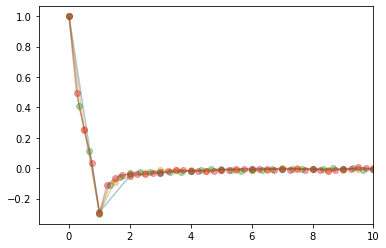

In [24]:
import matplotlib.pyplot as plt
from andi_datasets.datasets_theory import datasets_theory

deltats = np.arange(1, 5).tolist()
taus = np.arange(0, 100)
dt = datasets_theory()
trajs = dt.create_dataset(N_models = 200, T = 200, exponents = 0.5, models = 2)[:, 2:]

for deltat in deltats:
    
    
    v = vacf(trajs, deltat, taus)
        
    plt.plot(taus/deltat, v.flatten(), 'o-', alpha = 0.4)
    
plt.xlim(-1, 10)

# Convex hull

In [91]:
#| export
from scipy.spatial import ConvexHull

class ch_analysis():

    def get_changepoints(trajs, tau = 10, metric = 'volume'):
        CPs = []
        for traj in trajs:
            traj = np.array(traj)

            Sd = np.zeros(traj.shape[0]-2*tau)
            for k in range(traj.shape[0]-2*tau):
                if metric == 'volume':
                    Sd[k] = ConvexHull(traj[k:(k+2*tau)]).volume
                elif metric == 'area':
                    Sd[k] = ConvexHull(traj[k:(k+2*tau)]).area

            below_mean = Sd < Sd.mean()
            cp_traj = np.argwhere(below_mean[1:] != below_mean[:-1])+1
            CPs.append(cp_traj+tau)

        return CPs

Text(0, 0.5, '$S_d(n)$')

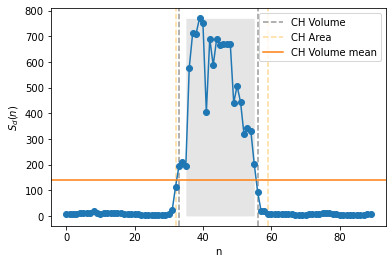

In [106]:
tau = 5
T = 100; on = 40; off = 60;

traj = np.random.randn(T, 2)
traj[on:off, :] = traj[on:off, :]*10
traj = traj.cumsum(0)

Sd = np.zeros(traj.shape[0]-2*tau)
for k in range(traj.shape[0]-2*tau):       
    Sd[k] = ConvexHull(traj[k:(k+2*tau)], ).volume
    
below_mean = Sd < Sd.mean()
CPs = np.argwhere(below_mean[1:] != below_mean[:-1])+1

CPs = ch_analysis.get_changepoints([traj], tau = tau)[0].flatten()-tau
CPs_a = ch_analysis.get_changepoints([traj], tau = tau, metric = 'area')[0].flatten()-tau

label_cp = 'CH Volume'
for cp in CPs:
    plt.axvline(cp, c = 'k', alpha = 0.4, ls = '--', label = label_cp)
    label_cp = ''
label_cp = 'CH Area'    
for cp in CPs_a:
    plt.axvline(cp, alpha = 0.4, ls = '--', c = 'orange', label = label_cp)
    label_cp = ''
    
plt.plot(Sd, '-o')
plt.axhline(Sd.mean(), label = 'CH Volume mean', c = 'C1',)
plt.legend()
plt.fill_betweenx(np.arange(Sd.max()), on-tau, off-tau, zorder = -1, alpha = 0.1, color = 'k', lw = 0)
plt.xlabel('n'); plt.ylabel(r'$S_d(n)$')
# plt.ylim(Sd.mean()-10, Sd.mean()+10)

# NBDEV Export

In [5]:
import nbdev; nbdev.nbdev_export()